In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Travaux pratiques : Équations différentielles

La version éxecutable, depuis un navigateur web, de ce rapport est disponible sur http://mybinder.org/repo/dzamlo/tp_edo/. C'est elle qui contient le code du TP. Pour executer tout le code, cliquez sur Cell->Run All

## Introduction


## Implémentation des solvers

Pour simplifier la comparaison avec un solveur déja exisitant, j'ai utilisé la même interface pour mes solveurs.

In [2]:
def runge_kutta_1_etage(fprime, y0, ts):
    try:
        ys = np.empty((len(ts), len(y0)))
    except TypeError:
        ys = np.empty(len(ts))
    ys[0] = y0
    for n in range(len(ts)-1):
        delta_t = ts[n+1]-ts[n]
        ys[n+1] = ys[n] + np.multiply(delta_t, fprime(ys[n], ts[n]))
    return ys

In [3]:
def runge_kutta_2_etages(fprime, y0, ts):
    try:
        ys = np.empty((len(ts), len(y0)))
    except TypeError:
        ys = np.empty(len(ts))
    ys[0] = y0
    for n in range(len(ts)-1):
        delta_t = ts[n+1]-ts[n]
        delta_t2 = (delta_t/2)
        fprime_n = fprime(ys[n], ts[n])
        ys[n+1] = ys[n] + np.multiply(delta_t, fprime(ys[n] + np.multiply(delta_t2, fprime_n), ts[n] + delta_t2))
    return ys

## Validation des solvers
Pour valider les solveurs, on commence par definir l'équation differentielle à resoudre ainsi que sa solution anlytique.

In [4]:
y0 = 10
C = 50
v = 1
F = lambda y, t: v*(1-np.divide(y,C))*y
y = lambda t: C/(1+((C-y0)/y0)*np.exp(np.multiply(-v,t)))

Ensuite on résoud l'equation avec les solveur et on fait un graphe des resultats.

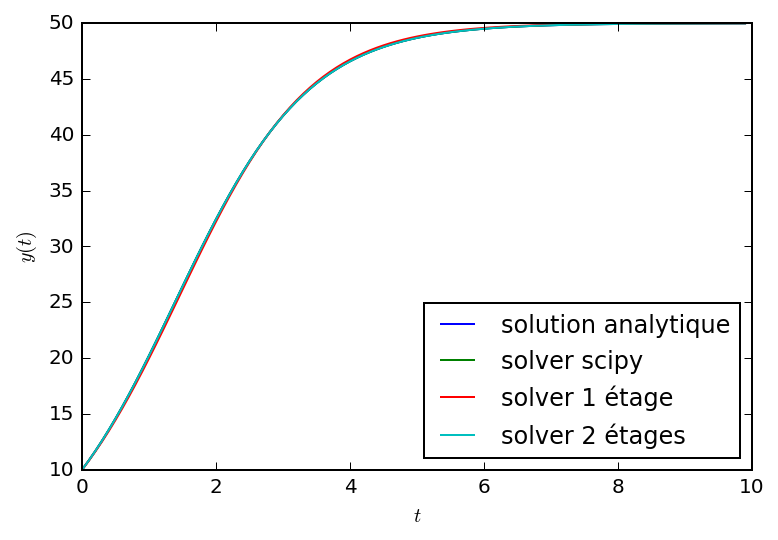

In [5]:
def delta_t_to_ts(delta_t, t0=0, tmax=10):
    return np.arange(t0, tmax, delta_t)
tmax = 10
ts = delta_t_to_ts(0.1, tmax=tmax)
value_y = y(ts)
value_runge_kutta_1 = runge_kutta_1_etage(F, y0, ts)
value_runge_kutta_2 = runge_kutta_2_etages(F, y0, ts)
value_scipy = odeint(F, y0, ts)[:, 0]
plt.plot(ts, value_y, label="solution analytique")
plt.plot(ts, value_scipy, label="solver scipy")
plt.plot(ts, value_runge_kutta_1, label="solver 1 étage")
plt.plot(ts, value_runge_kutta_2, label="solver 2 étages")
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.legend(loc='best');

On constate que pour cette equation differentielle simple les solveurs donnent des resultats proche de la solution analytique. Le solver scipy est un solveur déja existant que j'ai utilisé comme point de comparaison avec les solveurs que j'ai implémenté.

## Étude de convergence des solvers

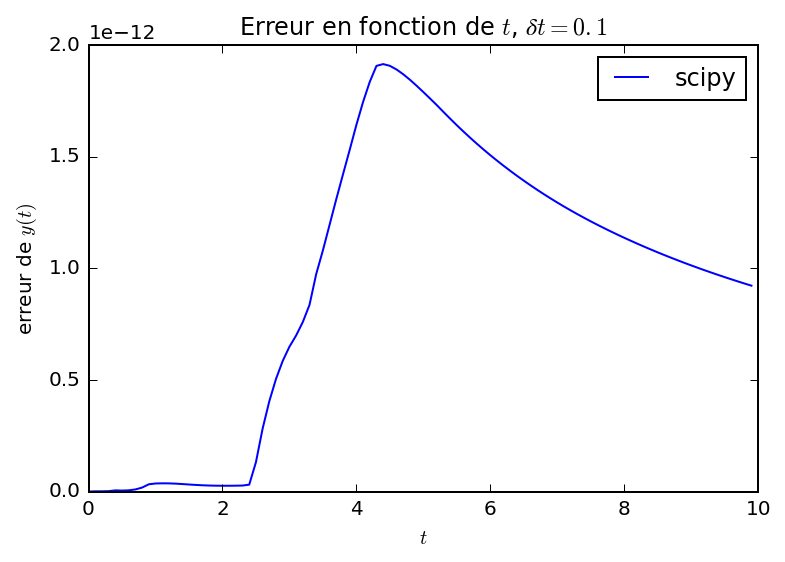

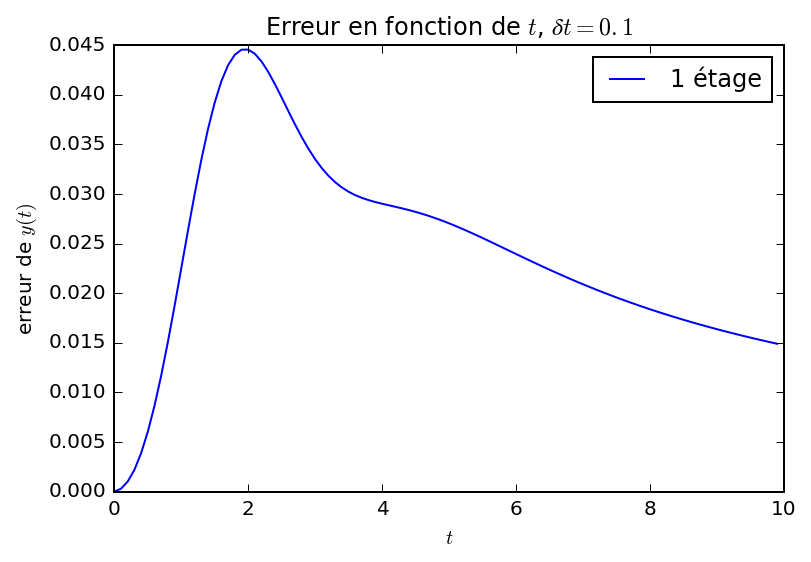

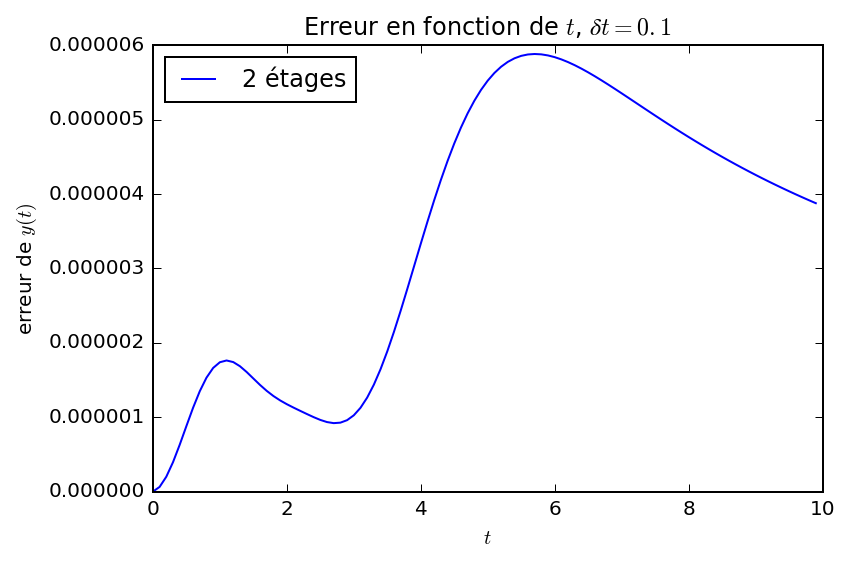

In [6]:
def compute_errors(values1, values2):
    diff = np.abs(values1-values2)
    diff_square = diff*diff
    errors = np.cumsum(diff_square)
    for i,v in enumerate(errors):
        errors[i] = v/(i+1)
    return errors

errors_scipy = compute_errors(value_y, value_scipy)
errors_runge_kutta_1 = compute_errors(value_y, value_runge_kutta_1)
errors_runge_kutta_2 = compute_errors(value_y, value_runge_kutta_2)

plt.plot(ts, errors_scipy, label="scipy")
plt.legend(loc="best")
plt.title("Erreur en fonction de $t$, $δt = 0.1$")
plt.xlabel("$t$")
plt.ylabel("erreur de $y(t)$")
plt.figure()
plt.plot(ts, errors_runge_kutta_1, label="1 étage")
plt.legend(loc="best")
plt.title("Erreur en fonction de $t$, $δt = 0.1$")
plt.xlabel("$t$")
plt.ylabel("erreur de $y(t)$")
plt.figure()
plt.plot(ts, errors_runge_kutta_2, label="2 étages")
plt.legend(loc="best")
plt.title("Erreur en fonction de $t$, $δt = 0.1$")
plt.xlabel("$t$")
plt.ylabel("erreur de $y(t)$");

On consate que l'erreur est beaucoup plus faible pour le solveur à 2 étages que celui à 1 étages. On constate également que le solveur éxistant fait encore mieux.

pente 2 étages / pente 1 étage: 2.00756339516


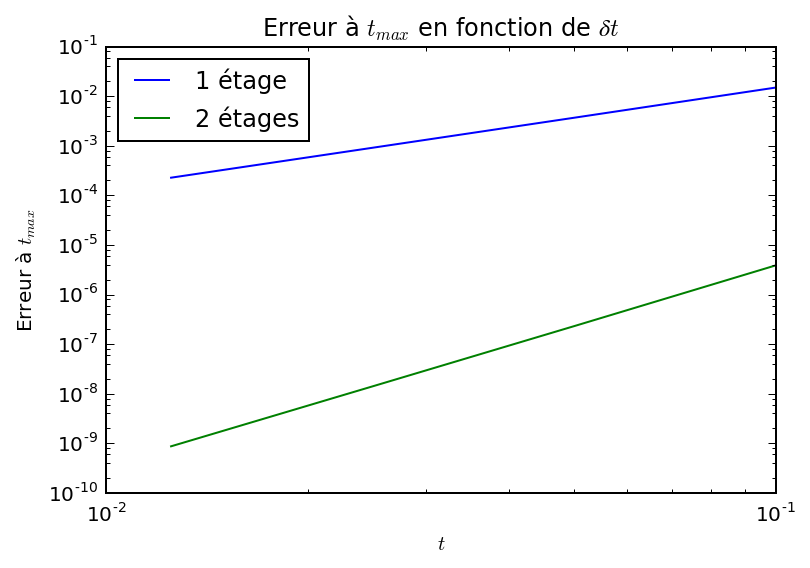

In [7]:
delta_ts = [0.1, 0.05, 0.025, 0.0125]
errors_runge_kutta_1 = np.zeros_like(delta_ts)
errors_runge_kutta_2 = np.zeros_like(delta_ts)

y_tmax = y(tmax)
for i, delta_t in enumerate(delta_ts):
    ts = delta_t_to_ts(delta_t, tmax=tmax)
    value_y_error = y(ts)
    errors_runge_kutta_1[i] = compute_errors(value_y_error, runge_kutta_1_etage(F, y0, ts))[-1]
    errors_runge_kutta_2[i] = compute_errors(value_y_error, runge_kutta_2_etages(F, y0, ts))[-1]

plt.loglog(delta_ts, errors_runge_kutta_1, label="1 étage")
plt.loglog(delta_ts, errors_runge_kutta_2, label="2 étages")
plt.legend(loc="best")
plt.title("Erreur à $t_{max}$ en fonction de $δt$");
plt.xlabel("$t$")
plt.ylabel("Erreur à $t_{max}$");
(slope1, _) = np.polyfit(np.log(delta_ts), np.log(errors_runge_kutta_1), 1)
(slope2, _) = np.polyfit(np.log(delta_ts), np.log(errors_runge_kutta_2), 1)
print("pente 2 étages / pente 1 étage:", slope2/slope1)

On constate que la pente de l'erreur en fonction de $δt$ est environ 2 fois plus élevée pour la methode à 2 étages que celle à 1 étage.

## Équation de Lorenz

In [8]:
beta = 8/3
sigma = 10
rho = 28

def lorenz(y,t):
    yx = y[0]
    yy = y[1]
    yz = y[2]
    dyx = sigma*(yy - yx)
    dyy = yx * (rho - yz) - yy
    dyz = yy * yx - beta*yz
    return [dyx, dyy, dyz]



ts_lorenz = delta_t_to_ts(0.001, tmax=1.5586522)
ts_lorenz = delta_t_to_ts(0.001, tmax=5*1.5586522)
y0_lorenz = [-0.9101673912, -1.922121396, 18.18952097]
#y0_lorenz = [0,0.5,1]
lorenz_runge_kutta_1 = runge_kutta_1_etage(lorenz, y0_lorenz, ts_lorenz)
lorenz_runge_kutta_2 = runge_kutta_2_etages(lorenz, y0_lorenz, ts_lorenz)
lorenz_scipy = odeint(lorenz, y0_lorenz, ts_lorenz)

In [9]:
from mpl_toolkits.mplot3d import Axes3D
def draw_lorenz(y0, ts, fns = [odeint, runge_kutta_1_etage, runge_kutta_2_etages], labels = ["scipy", "1 étage", "2 étages"], title=None):
    values = map(lambda fn: fn(lorenz, y0, ts), fns)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for label,value in zip(labels, values):
        ax.plot(value[:, 0], value[:, 1], value[:, 2], label=label)
    ax.legend(loc='best')
    if title is not None:
        ax.set_title(title)

### Trajectoire avec conditions initiales quelconques

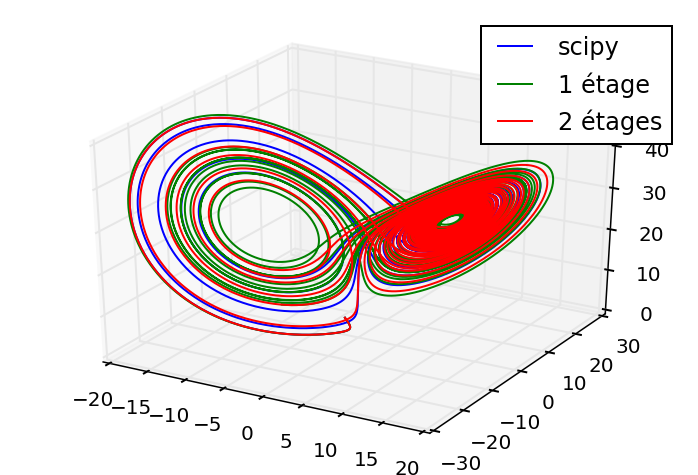

In [19]:
y0_lorenz = np.random.rand(3)*10-5 # valeurs aléatoires entre -5 et 5
ts_lorenz = delta_t_to_ts(0.001, tmax=30)
draw_lorenz(y0_lorenz, ts_lorenz)

Comme sur la figure de l'énoncé, les trajectoires des sorte de 8 autour de deux points.

### Orbite périodique

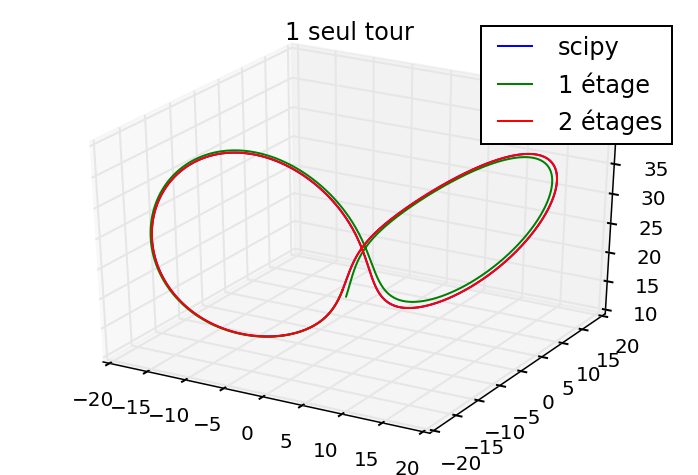

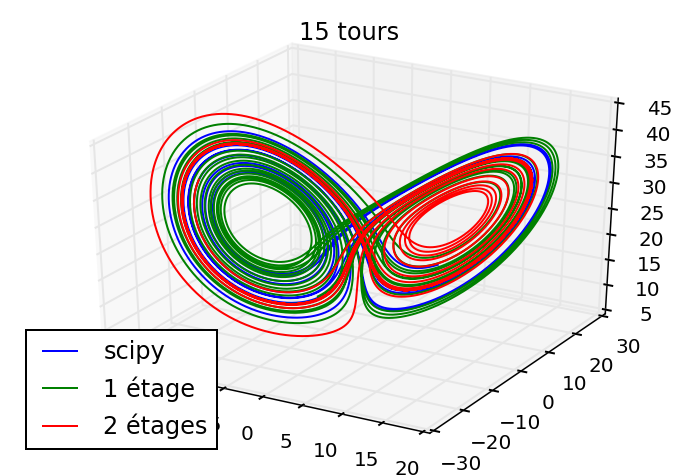

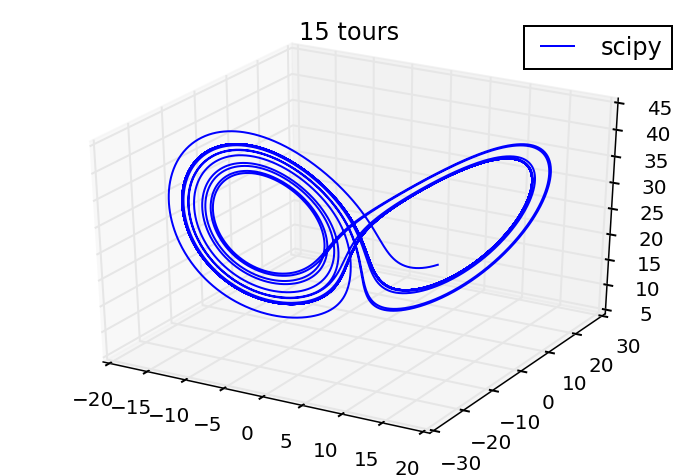

In [20]:
y0_lorenz = [-0.9101673912, -1.922121396, 18.18952097]
ts_lorenz = delta_t_to_ts(0.001, tmax=1.5586522)
draw_lorenz(y0_lorenz, ts_lorenz, title = "1 seul tour")
ts_lorenz = delta_t_to_ts(0.001, tmax=15*1.5586522)
draw_lorenz(y0_lorenz, ts_lorenz, title = "15 tours")

Après un seul tour, on constate que la méthode à 1 étage a déja devié significativent de la trajectoire. Ce n'est pas le cas des autres solveurs. Apres 15 tours tout les soveur on devié signifactivement de la trajectoire.